In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
team_names = ['atlanta_hawks','boston_celtics','brooklyn_nets','charlotte_hornets','chicago_bulls',\
              'cleveland_cavaliers','dallas_mavericks','denver_nuggets','detroit_pistons','golden_state_warriors',\
             'houston_rockets','indiana_pacers','los_angeles_clippers','los_angeles_lakers','memphis_grizzlies',\
             'miami_heat','milwaukee_bucks','minnesota_timberwolves','new_york_knicks','oklahoma_city_thunder',\
             'orlando_magic','philadelphia_76ers','phoenix_suns','portland_trailblazers','sacramento_kings',\
             'san_antonio_spurs','toronto_raptors','utah_jazz','washington_wizards']

In [3]:
#Define what makes a good team. Somewhat arbitrary cutoffs but based on 
#statistics of p(winning championship | X wins). 
def historical_ranking_classifier(value):
    if value >= 65:
        return "Legendary"
    elif value >=60 and value<65: 
        return "Historically Great Contenders"
    elif value >= 55 and value<60: 
        return "Serious contenders"
    elif value >= 50 and value<55: 
        return "Good Contenders"
    elif value >= 40 and value < 50: 
        return "Borderline Playoff Team"
    else: 
        return "Poor"

In [4]:
#Function to get team records
def get_team_records(team_names): 
    df = pd.DataFrame({})
    for team in team_names: 
        url = 'https://www.landofbasketball.com/teams/records_' + team + '.htm'
        data = requests.get(url).text
        soup = BeautifulSoup(data, 'html.parser')
        tables = soup.find_all('table')  
        try: 
            temp = pd.read_html(str(tables),skiprows=2)[1]
        except: 
            temp = pd.read_html(str(tables),skiprows=2)[0]
        temp.columns = ['Season','Team','Record','Win%','Standing','Conf','a','b','c']
        temp = temp[['Season','Team','Record']]   
        df = pd.concat([df,temp])   
    return df

In [5]:
df = get_team_records(team_names)
df.head()

,Season,Team,Record
0,2022-23,Hawks,13-11
1,2021-22,Hawks,43-39
2,2020-21,Hawks,41-31
3,2019-20,Hawks,20-47
4,2018-19,Hawks,29-53


In [6]:
#Old school teams. 
drop_list = ['Braves','Blackhawks','Zephyrs','Packers']
for drop in drop_list: 
    df = df[df['Team']!=drop]

In [7]:
df = df.sort_values(['Team','Season']).reset_index(drop=True)
df.head()

,Season,Team,Record
0,1963-64,76ers,34-46
1,1964-65,76ers,40-40
2,1965-66,76ers,55-25
3,1966-67,76ers,68-13
4,1967-68,76ers,62-20


In [8]:
#Remove this season since it isn't complete! 
df = df[df['Season']!='2022-2023']

In [9]:
#Coonvert to single number representation (2012-2013 season will be represented as the 2013 season)
temp = df['Season'].str.split('-', expand=True)
temp.columns = ['Season','Year_p2']
temp['Season'] = temp['Season'].astype(int) + 1
temp = temp[['Season']]
df = df.drop(['Season'],axis=1)
df = pd.concat([temp,df],axis=1)
df.head()

,Season,Team,Record
0,1964,76ers,34-46
1,1965,76ers,40-40
2,1966,76ers,55-25
3,1967,76ers,68-13
4,1968,76ers,62-20


In [10]:
#82 game NBA seasons.
df = df[df['Season'] > 1970]

In [11]:
#Convert record into just wins since W+L = 82
temp = df['Record'].str.split('-', expand=True)
temp.columns = ['Wins','Loss']
df = pd.concat([df,temp],axis=1)
df = df[['Team','Season','Wins']]
df.head()

,Team,Season,Wins
7,76ers,1971,47
8,76ers,1972,30
9,76ers,1973,9
10,76ers,1974,25
11,76ers,1975,34


In [12]:
#Compute the rolling sums over 4 year increments. 
df_results = pd.DataFrame(df.groupby('Team')['Wins'].rolling(4).sum()).reset_index().drop(['level_1'],axis=1)
df_results.head()

,Team,Wins
0,76ers,NaN
1,76ers,NaN
2,76ers,NaN
3,76ers,111.0
4,76ers,98.0


In [13]:
#Remove the missing data constructed.
df_results = df_results.dropna()
df_results.head()

,Team,Wins
3,76ers,111.0
4,76ers,98.0
5,76ers,114.0
6,76ers,155.0
7,76ers,185.0


In [14]:
#Construct the final pandas dataframe. Loop through the teams and update year info. 
final = pd.DataFrame({})
for team in df_results.Team.unique().tolist(): 
    temp = df[df['Team'] == team]
    
    a = temp.Season.min()
    years = []
    era_label = []
    for i in range(temp.shape[0]): 
        r = str(a) + ' - ' + str(a+4-1)
        years.append(r)
        a = a + 1
        if a>=1970 and a<=1973: 
            era_label.append('The early 70s ' + team)
        elif a>=1974 and a<=1977: 
            era_label.append('The mid 70s ' + team)
        elif a>=1978 and a<=1979: 
            era_label.append('The late 70s ' + team)
        elif a>=1980 and a<=1983: 
            era_label.append('The early 80s ' + team)
        elif a>=1984 and a<=1987: 
            era_label.append('The mid 80s ' + team)
        elif a>=1988 and a<=1989: 
            era_label.append('The late 80s ' + team)            
        elif a>=1990 and a<=1993: 
            era_label.append('The early 90s ' + team)
        elif a>=1994 and a<=1997: 
            era_label.append('The mid 90s ' + team)
        elif a>=1998 and a<=1999: 
            era_label.append('The late 90s ' + team)          
        elif a>=2000 and a<=2003: 
            era_label.append('The early 2000s ' + team)
        elif a>=2004 and a<=2007: 
            era_label.append('The mid 2000s ' + team)
        elif a>=2008 and a<=2009: 
            era_label.append('The late 2000s ' + team)  
            
        elif a>=2010 and a<=2013: 
            era_label.append('The early 2010s ' + team)
        elif a>=2014 and a<=2017: 
            era_label.append('The mid 2010s ' + team)
        elif a>=2018 and a<=2019: 
            era_label.append('The late 2010s ' + team) 
        else: 
            era_label.append('The early 2020s ' + team)
        
            
    t = pd.DataFrame({'Year Range':years,'Era':era_label})
    #t = pd.DataFrame([years,era_label],columns = ['Year Range','Era Label'])
    
    temp = df_results[df_results['Team'] == team]
    temp = pd.concat([temp.reset_index(drop=True),t.reset_index(drop=True)],axis=1)
    final = pd.concat([final.reset_index(drop=True),temp.reset_index(drop=True)])

In [15]:
final = final.dropna()
final = final.reset_index(drop=True)
final.head()

,Team,Wins,Year Range,Era
0,76ers,111.0,1971 - 1974,The early 70s 76ers
1,76ers,98.0,1972 - 1975,The early 70s 76ers
2,76ers,114.0,1973 - 1976,The mid 70s 76ers
3,76ers,155.0,1974 - 1977,The mid 70s 76ers
4,76ers,185.0,1975 - 1978,The mid 70s 76ers


<AxesSubplot:>

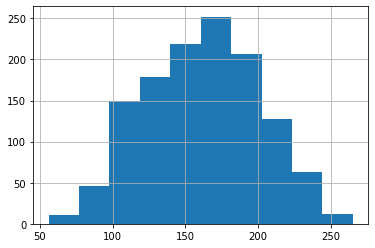

In [16]:
final.Wins.hist()

In [17]:
final = final.sort_values(['Wins'],ascending=False)
final.head()

,Team,Wins,Year Range,Era
1238,Warriors,265.0,2015 - 2018,The mid 2010s Warriors
1237,Warriors,258.0,2014 - 2017,The mid 2010s Warriors
1239,Warriors,255.0,2016 - 2019,The mid 2010s Warriors
608,Lakers,251.0,1985 - 1988,The mid 80s Lakers
244,Celtics,251.0,1984 - 1987,The mid 80s Celtics


In [18]:
eras = final.drop_duplicates(['Team','Era']).reset_index(drop=True)
eras['Wins/Year'] = eras['Wins'] / 4
eras['Historical Ranking'] = eras['Wins/Year'].map(historical_ranking_classifier)
eras.head(50)

,Team,Wins,Year Range,Era,Wins/Year,Historical Ranking
0,Warriors,265.0,2015 - 2018,The mid 2010s Warriors,66.25,Legendary
1,Lakers,251.0,1985 - 1988,The mid 80s Lakers,62.75,Historically Great Contenders
2,Celtics,251.0,1984 - 1987,The mid 80s Celtics,62.75,Historically Great Contenders
3,Bulls,250.0,1995 - 1998,The mid 90s Bulls,62.50,Historically Great Contenders
4,Bucks,248.0,1971 - 1974,The early 70s Bucks,62.00,Historically Great Contenders
5,Lakers,247.0,1987 - 1990,The late 80s Lakers,61.75,Historically Great Contenders
6,Spurs,245.0,2014 - 2017,The mid 2010s Spurs,61.25,Historically Great Contenders
7,76ers,244.0,1980 - 1983,The early 80s 76ers,61.00,Historically Great Contenders
8,Celtics,244.0,1982 - 1985,The early 80s Celtics,61.00,Historically Great Contenders
9,Supersonics,241.0,1994 - 1997,The mid 90s Supersonics,60.25,Historically Great Contenders


In [22]:
temp = eras[eras['Historical Ranking'] == 'Serious contenders']
temp['Era'].str.split('0s', 1, expand=True)

,0,1
13,The mid 200,Spurs
14,The mid 7,Celtics
15,The mid 200,Mavericks
16,The late 200,Lakers
17,The late 200,Celtics
18,The early 200,Spurs
19,The mid 200,Suns
20,The early 200,Lakers
21,The early 201,Spurs
22,The early 8,Lakers


<AxesSubplot:>

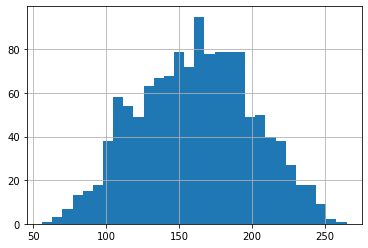

In [19]:
final.Wins.hist(bins=30)

In [20]:
final.drop_duplicates(['Team','Era'],keep='last').sort_values(['Wins']).reset_index(drop=True).head(40)

,Team,Wins,Year Range,Era
0,Grizzlies,56.0,1996 - 1999,The mid 90s Grizzlies
1,Grizzlies,63.0,1997 - 2000,The late 90s Grizzlies
2,Bulls,66.0,1999 - 2002,The early 2000s Bulls
3,Pistons,69.0,2020 - 2023,The early 2020s Pistons
4,Clippers,72.0,1998 - 2001,The late 90s Clippers
5,Mavericks,74.0,1991 - 1994,The early 90s Mavericks
6,76ers,75.0,2014 - 2017,The mid 2010s 76ers
7,Timberwolves,75.0,1992 - 1995,The early 90s Timberwolves
8,Warriors,76.0,1998 - 2001,The late 90s Warriors
9,Grizzlies,76.0,1999 - 2002,The early 2000s Grizzlies
